In [19]:
import torch
import cv2
import numpy as np
from torchvision import datasets, transforms
import torchvision

# 1. Using torchvision to load data and preprocess
transform = transforms.Compose([transforms.ToTensor(),  # transform image to tensor
                                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),  # normalize
                              ])
# load training dataset and testing dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)


# 2. define CNN
import torch.nn as nn
import torch.nn.functional as F

class MyModel(nn.Module):  #  inheriate nn.Module
    # define net structure
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    # define forward propagation
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

Net = MyModel()
print(Net)

Files already downloaded and verified
Files already downloaded and verified
MyModel(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


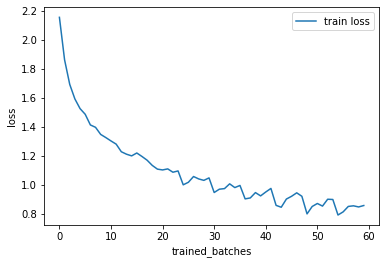

In [20]:
# 3. define loss function and optimizer
import torch.optim as optim
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()  # use cross entropy for classification
optimizer = optim.SGD(Net.parameters(), lr=0.001, momentum=0.9)  # use SGD as optimizer


# 4. train the CNN
# run with GPU
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
Net.to(device)
epochs = 10  # loop over the dataset epochs times, batch_size = 4, train as group of four images
total_loss = []
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get inputs, data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # load the data to GPU
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = Net(inputs)  # forward propagation to get outputs
        loss = criterion(outputs, labels)  # get loss
        loss.backward()  # backward propagation
        optimizer.step()  # update parameters

        # print the training process
        running_loss += loss.item()
        if (i+1) % 2000 == 0:  # print loss every 1000 batch(4000 images)
            #print('epoch {}：{:5d} times：current loss is：{:.3f}'.format(epoch+1, i+1, running_loss/2000))
            total_loss.append(running_loss/2000)
            running_loss = 0.0

plt.xlabel('trained_batches')
plt.ylabel('loss')
plt.plot(total_loss)
plt.legend(['train loss'])
plt.show()

In [21]:
# 5. testing the accuracy

correct = 0
total = 0

with torch.no_grad():  # not follow the gradient
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device) # load the data to GPU
        outputs = Net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy on testing dataset is：{:.3f}%'.format(correct*100/total))


Accuracy on testing dataset is：60.400%
